# Read Dataset


## Factor DF

In [39]:
import pandas as pd

df = pd.read_csv("feature_data/data.csv")

df = df.drop(columns=['Unnamed: 0'])

df


,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess
0,2012-02-29,AAP,16.706458,3.311468,74.872002,0.017554,0.067338,0.203171,4.42,-1.71,0.43,-0.48,-0.01,0.0000,0.017554
1,2012-03-31,AAP,17.332681,3.311468,77.731010,0.028689,0.071533,0.367164,3.11,-0.47,1.14,-0.54,0.74,0.0000,0.028689
2,2012-04-30,AAP,17.964775,3.311468,80.565750,0.027881,0.071351,0.354526,-0.85,-0.55,-0.78,1.30,0.65,0.0000,0.027881
3,2012-05-31,AAP,13.118705,3.447840,64.013748,0.031124,0.070729,0.407354,-6.19,-0.12,-1.07,2.08,2.31,0.0001,0.031024
4,2012-06-30,AAP,12.269784,3.447840,59.923603,0.018280,0.096397,0.178720,3.89,0.84,0.62,-1.10,0.46,0.0000,0.018280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17980,2024-08-31,XOM,14.107656,0.771855,114.883614,0.012588,0.052356,0.144777,1.61,-3.65,-1.13,0.85,0.86,0.0048,0.007788
17981,2024-09-30,XOM,14.021531,0.771855,114.182266,0.009021,0.051371,0.097898,1.74,-1.02,-2.59,0.04,-0.26,0.0040,0.005021
17982,2024-10-31,XOM,13.968900,0.771855,113.753670,0.003723,0.049151,0.031893,-0.97,-0.88,0.89,-1.38,1.03,0.0039,-0.000177
17983,2024-11-30,XOM,14.689913,0.737662,115.847267,0.011724,0.037114,0.141942,6.51,4.78,-0.05,-2.62,-2.17,0.0040,0.007724


In [40]:
# split the data into train and test sets
#train_df = df[df['date'] < '2024-01-01']
#test_df = df[df['date'] >= '2024-01-01']

#train_df = df

# Estimate returns & Covariances

In [41]:
from typing import Dict, List, Tuple
import numpy as np
#import mgarch
factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]


# ----- helper #1 :   β̂  and  F̂  --------------------------------
def fit_beta(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # 1) strip rows that contain any non-finite value
    row_mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    Xc, Yc   = X[row_mask], Y[row_mask]

    beta, *_ = np.linalg.lstsq(Xc, Yc, rcond=None)               # (d_x, d_y)
    resid    = Yc - Xc @ beta                                    # (n, d_y)
    F_hat    = np.diag(resid.var(axis=0, ddof=1))              # (d_y, d_y)
    return beta, F_hat


# ----- helper #2 :   one-step mean & cov ------------------------
def forecast_one_step(x_i, W_i, beta, F_hat):
    y_hat = x_i @ beta                                         # (d_y,)
    V_hat = beta.T @ W_i @ beta + F_hat                        # (d_y, d_y)
    return y_hat, V_hat

# ---- helper #3 : DCC-GARCH forecast of factor covariance ------
#def dcc_garch_cov(X, ndays=1):
    #dist = 't'
    #vol = mgarch.mgarch(dist)
    #vol.fit(X)
    #W_t = vol.predict(ndays)['cov']
    #return W_t

In [42]:
df['label'] = df.groupby('ticker')['close_price'].shift(-1).gt(df['close_price']).astype(int) * 2 - 1

In [43]:
df['ret'] = df.groupby('ticker')['close_price'].pct_change().shift(-1).fillna(0)

In [44]:
df['ret_excess'] = df['ret']

In [45]:
# get the how many 1s and 0s in the label column
label_counts = df['label'].value_counts()
print("Label counts:")
print(label_counts)

Label counts:
label
 1    10093
-1     7892
Name: count, dtype: int64


In [46]:
df

,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess,label,ret
0,2012-02-29,AAP,16.706458,3.311468,74.872002,0.017554,0.067338,0.203171,4.42,-1.71,0.43,-0.48,-0.01,0.0000,0.038185,1,0.038185
1,2012-03-31,AAP,17.332681,3.311468,77.731010,0.028689,0.071533,0.367164,3.11,-0.47,1.14,-0.54,0.74,0.0000,0.036469,1,0.036469
2,2012-04-30,AAP,17.964775,3.311468,80.565750,0.027881,0.071351,0.354526,-0.85,-0.55,-0.78,1.30,0.65,0.0000,-0.205447,-1,-0.205447
3,2012-05-31,AAP,13.118705,3.447840,64.013748,0.031124,0.070729,0.407354,-6.19,-0.12,-1.07,2.08,2.31,0.0001,-0.063895,-1,-0.063895
4,2012-06-30,AAP,12.269784,3.447840,59.923603,0.018280,0.096397,0.178720,3.89,0.84,0.62,-1.10,0.46,0.0000,0.028291,1,0.028291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17980,2024-08-31,XOM,14.107656,0.771855,114.883614,0.012588,0.052356,0.144777,1.61,-3.65,-1.13,0.85,0.86,0.0048,-0.006105,-1,-0.006105
17981,2024-09-30,XOM,14.021531,0.771855,114.182266,0.009021,0.051371,0.097898,1.74,-1.02,-2.59,0.04,-0.26,0.0040,-0.003754,-1,-0.003754
17982,2024-10-31,XOM,13.968900,0.771855,113.753670,0.003723,0.049151,0.031893,-0.97,-0.88,0.89,-1.38,1.03,0.0039,0.018405,1,0.018405
17983,2024-11-30,XOM,14.689913,0.737662,115.847267,0.011724,0.037114,0.141942,6.51,4.78,-0.05,-2.62,-2.17,0.0040,-0.103425,-1,-0.103425


In [47]:
# -------------------------------------------------------------
# 1.  Build monthly factor (X_df) and asset-return (Y_df) tables

Y_df = (df
        .pivot(index='date', columns='ticker', values='ret_excess') # ret_excess can be used or ret
        .sort_index())

X_df = (df[['date'] + factor_cols]
        .drop_duplicates('date')
        .set_index('date')
        .sort_index())
# create a label_df
label_df = (df
            .pivot(index='date', columns='ticker', values='label')
            .sort_index())

# ------------------------------------------------------------------
# 1.  Find ticker columns with *any* NaNs in Y_df
# ------------------------------------------------------------------
bad_tickers = Y_df.columns[Y_df.isna().any()]

print(f"🗑  Dropping {len(bad_tickers)} tickers with missing returns:")
print(", ".join(map(str, bad_tickers)))

# ------------------------------------------------------------------
# 2.  Drop them from Y_df  (axis=1 ⇒ columns)
# ------------------------------------------------------------------
Y_df = Y_df.drop(columns=bad_tickers)

# ------------------------------------------------------------------
# 3.  OPTIONAL: keep your other pivot tables in sync
#     (uncomment if you have X_df, label_df, etc. with same columns)
# ------------------------------------------------------------------
# X_df      = X_df.drop(columns=bad_tickers, errors="ignore")
label_df  = label_df.drop(columns=bad_tickers, errors="ignore")
# Sigma_fore = Sigma_fore[np.ix_(good_mask, good_mask)]  # inside loop

# ------------------------------------------------------------------
# 4.  Verify — there should be zero NaNs left
# ------------------------------------------------------------------
assert not Y_df.isna().any().any(), "Still NaNs lurking in Y_df!"
print("✅  Y_df is now NaN-free and has", Y_df.shape[1], "tickers.")


🗑  Dropping 55 tickers with missing returns:
ABBV, ABM, ACA, ACT, ADEA, ADMA, AESI, AHCO, AL, ALRM, AMN, AMPH, AMR, ANGI, ANIP, AORT, APAM, ARLO, AROC, ASIX, ASO, ATEN, ATGE, AUB, AX, BAC, BANC, BH, BL, BLMN, BTU, CABO, CALM, CARG, CARS, CC, CHEF, CLB, CNR, CRC, CRGY, CRK, CWEN, ENR, EPC, ESI, GOGO, GOOG, HCC, IAC, LUMN, MA, META, MSGS, TMUS
✅  Y_df is now NaN-free and has 86 tickers.


In [48]:
# 1) make sure every index really *is* a DatetimeIndex
X_df.index      = pd.to_datetime(X_df.index)
Y_df.index      = pd.to_datetime(Y_df.index)
label_df.index  = pd.to_datetime(label_df.index)
df['date'] = pd.to_datetime(df['date'])

In [49]:
# Every row is month-end already ⇒ just iterate over the index
month_ends = X_df.index.sort_values()

lookback = 12          # e.g. use the past 12 months
month_ends = month_ends[lookback:]

In [50]:
month_ends

DatetimeIndex(['2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31',
               '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', length=143, freq=None)

In [51]:
def make_spd(M, eps=1e-6):
    M = (M + M.T) * 0.5  # enforce symmetry
    jitter = eps
    I = np.eye(M.shape[0])
    for _ in range(10):
        try:
            # This will error if M is not SPD
            np.linalg.cholesky(M)
            return M
        except np.linalg.LinAlgError:
            M = M + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

results = []
tickers = Y_df.columns.unique()
for me_date in month_ends:

    # ---------- 1) pick the estimation window ------------
    win_mask  = (X_df.index <= me_date)                     & \
                (X_df.index >  me_date - pd.offsets.MonthEnd(lookback))

    X_window  = X_df.loc[win_mask]
    Y_window  = Y_df.loc[win_mask]

    if len(X_window) < 2:
        continue   # still not enough data – skip

    # ---------- 2)  β̂ , F̂  from the window --------------
    beta_hat, F_hat = fit_beta(X_window.values, Y_window.values)

    # ---------- 3)  Σ̂ (covariance)  ----------------------
    # but most people just use a sample/Exp-Wtd cov here:
    W_hat = np.cov(X_window.values.T, ddof=1)
    #W_hat = dcc_garch_cov(X_window.values)
    
    x_today      = X_df.loc[me_date].values
    mu_fore, Sigma_fore = forecast_one_step(x_today, W_hat, beta_hat, F_hat)
    #  └─ make sure your forecast function is set up for “+1 month”,
    #     not “+1 trading day”.

    W = 12
    R_hist = (Y_df.loc[Y_df.index <= me_date]
                .tail(W)         # 12 rows = 12 months
                .T.values)       # (n_assets × W)
               
    # 5) features ----------------------------------------
    feature_list = ['exp_ret', 'vol','mom', 'pe_exi', 'de_ratio', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

    monthly = (df
               .set_index(['date','ticker'])
               .loc[me_date]
               .reindex(tickers))
    X_feat = monthly[feature_list].values

    # Standardize X_feat now
    mean = X_feat.mean(axis=0, keepdims=True)
    std = X_feat.std(axis=0, keepdims=True) + 1e-8  # to avoid division by zero
    X_feat = (X_feat - mean) / std
    
    # 6) labels ------------------------------------------
    y_vec = label_df.loc[me_date, tickers].values

    # 7) get row of Y_df for the current month-end
    real_returns = Y_df.loc[me_date, tickers].values

    # 8) get the real covariance matrix for the current month-end
    real_sigma = np.cov(Y_df.loc[Y_df.index <= me_date].tail(W).T, ddof=1)
    real_sigma = make_spd(real_sigma)
    # 9) store snapshot ----------------------------------
    results.append(dict(date         = me_date,
                        X_feat       = X_feat,
                        returns_hist = R_hist,
                        y            = y_vec.astype(np.double),
                        mu_fore      = mu_fore.astype(np.double),
                        Sigma_fore   = Sigma_fore.astype(np.double),
                        beta         = beta_hat,
                        F_hat        = F_hat,
                        W_hat        = W_hat,
                        real_returns = real_returns.astype(np.double),
                        real_sigma   = real_sigma.astype(np.double)))

In [52]:
import numpy as np

# --- helper --------------------------------------------------------
def is_spd(mat: np.ndarray, tol: float = 1e-8) -> bool:
    """
    Return True if `mat` is symmetric-positive-definite.
    • First check symmetry (fast) – avoids false negatives from tiny asymmetry
    • Then try a Cholesky factorisation.  If it succeeds, SPD.
    • `tol` lets you ignore round-off noise on symmetry test.
    """
    if not np.allclose(mat, mat.T, atol=tol, rtol=0):
        return False
    try:
        np.linalg.cholesky(mat)
        return True
    except np.linalg.LinAlgError:
        return False

# --- scan the results list ----------------------------------------
bad = []                 # collect (index, date) for matrices that fail
for i, snap in enumerate(results):
    if not is_spd(snap["Sigma_fore"]):
        bad.append((i, snap["date"]))
    if not is_spd(snap["real_sigma"]):
        bad.append((i, snap["date"]))
# --- quick report --------------------------------------------------
total = len(results)
print(f"Σ̂ SPD check: {total - len(bad)}/{total} pass, {len(bad)} fail")

if bad:
    print("First few failures:")
    for idx, d in bad[:10]:
        print(f"  #{idx:3d}  {d}")



Σ̂ SPD check: 143/143 pass, 0 fail


# Neural Network

In [53]:
import torch
import torch.nn as nn
from qpth.qp import QPFunction
torch.manual_seed(99)
    
def sanitise_spd(M: torch.Tensor,
                 name: str = "Q",
                 eps: float = 1e-6) -> torch.Tensor:
    """
    1. reports NaN/Inf, duplicate rows, condition number, min/max eigenvalues
    2. drops exact duplicate rows/cols (they kill Cholesky)
    3. adds minimal jitter to make SPD
    """
    #def _report(tag, val):  # compact helper
        #print(f"[{name}] {tag}: {val}")

    # 0) NaN / Inf check -------------------------------------------------
    if torch.isnan(M).any() or torch.isinf(M).any():
        raise ValueError(f"[{name}] contains NaN or Inf – cannot factorise")

    # 1) deduplicate rows/cols ------------------------------------------
    #    (X rows that are numerically identical give zero-variance directions)
    # NOTE: this assumes you constructed M as  y yᵀ ⊙ X Xᵀ
    #       If that is not the case just delete the dedup block.
    with torch.no_grad():
        diag = torch.diag(M)
        mask_nonzero = diag > 0      # rows with all-zero features have 0 on diag
        if mask_nonzero.sum() < len(mask_nonzero):
            #_report("duplicate/zero rows removed",
                    #nt(len(mask_nonzero) - mask_nonzero.sum()))
            M = M[mask_nonzero][:, mask_nonzero]

    # 2) minimal jitter --------------------------------------------------
    eigvals = torch.linalg.eigvalsh(M)
    λmin    = eigvals.min().item()
    λmax    = eigvals.max().item()
    cond    = λmax / max(λmin, eps)
    #_report("λ_min",  λmin)
    #_report("λ_max",  λmax)
    #_report("cond",   cond)

    jitter  = max(eps, -λmin + eps)
    M       = M + jitter * torch.eye(M.size(0), device=M.device, dtype=M.dtype)

    # final safety: Cholesky must succeed now
    try:
        torch.linalg.cholesky(M)
    except RuntimeError as e:
        raise RuntimeError(f"[{name}] still not SPD even after jitter = {jitter}") from e

    return M

class EndToEndSVM_MVO_Sigmoid(nn.Module):
    def __init__(self,
                 in_features: int,
                 C_svm_init: float,
                 eps: float,
                 tau_init: float,
                 lambda_hinge_init: float
            ):
        """
        in_features : number of raw features per asset
        C_svm_init       : SVM dual box-constraint
        eps         : jitter to ensure all Q-matrices are SPD
        tau_init         : sigmoid temperature for soft gating
        """
        super().__init__()
        # 1)  make the learnable projection W (d × d, no bias)
        self.embed = nn.Linear(in_features, in_features, bias=False).double()

        # 2)  start it as an identity matrix instead of tiny random numbers
        nn.init.eye_(self.embed.weight)          # ← this line
        with torch.no_grad():
            self.embed.weight += 0.01 * torch.randn_like(self.embed.weight)
            
        self.log_C = nn.Parameter(torch.log(torch.tensor([C_svm_init], dtype=torch.double)))
        # self.log_tau = nn.Parameter(torch.log(torch.tensor([tau_init], dtype=torch.double)))
        self.tau = tau_init
        self.eps = eps
        # self.log_lambda_hinge = nn.Parameter(torch.log(torch.tensor([lambda_hinge_init], dtype=torch.double)))
        self.lambda_hinge = lambda_hinge_init 

    def forward(self,
                X_feat: torch.Tensor,     # (n,d)
                y: torch.Tensor,          # ±1
                mu_est: torch.Tensor,     # (n,)  
                Sigma_est: torch.Tensor,  # (n,n) 
                return_goal: float
               ) -> torch.Tensor:
        n, d = X_feat.shape
        # A. raw input
        #_check("X_feat", X_feat)


        # 1) feature embedding
        Xp = self.embed(X_feat.double())
        #_check("Xp", Xp)
        y  = y.view(-1).double()           # now y is float64 ±1

        # 2) SVM dual QP
        K      = Xp @ Xp.t()                             # (n, n)
        #_check("K", K)

        yy    = y.unsqueeze(1) * y.unsqueeze(0)  # (n,n) float64
        Q_svm  = sanitise_spd((y[:,None] * y[None,:]) * K, name="Q_svm", eps=self.eps)
        #_check("Q_svm", Q_svm)
        p_svm  = -torch.ones(n, device=Xp.device, dtype=Xp.dtype)

        G_svm  = torch.cat([
            -torch.eye(n, device=Xp.device, dtype=Xp.dtype),
             torch.eye(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n, n)

        C_svm = torch.exp(self.log_C)

        h_svm  = torch.cat([
            torch.zeros(n, device=Xp.device, dtype=Xp.dtype),
            C_svm * torch.ones(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n,)

        A_svm  = y.view(1,-1)#.to(Xp)                     # (1, n)
        b_svm  = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)
        # ---------------------------------------------------------------
        # handle single-class case (all +1  *or*  all –1)
        # ---------------------------------------------------------------
        if (y == y[0]).all():              # every label identical
            A_svm = torch.empty(0, n, device=Xp.device, dtype=Xp.dtype)  # shape (0, n)
            b_svm = torch.empty(0,       device=Xp.device, dtype=Xp.dtype)  # shape (0,)
            print("Warning: all labels identical, no SVM hyperplane constructed.")
        else:
            A_svm = y.view(1, -1)                                           # (1, n)
            b_svm = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)        # (1,)

        alpha      = QPFunction(verbose=False)(
                    Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm
                 )                                  # (n,)
        alpha = torch.clamp(alpha, min=0.0, max=C_svm.item())
        # 3) build hyperplane and score
        # after solving for alpha
        # construct w_svm properly:
        # make sure alphas is a 1-D tensor of length 
        alpha = alpha.view(-1)               

        # ensure y is double or double to match alphas dtype
        y = y.to(alpha.dtype)            

        # elementwise product alpha_i * y_i
        alpha_y = alpha * y                
        w_svm = Xp.t().mv(alpha_y)                   # or torch.matmul(X.t(), alpha_y)

        scores = Xp @ w_svm                 # (n_assets,)

        # diagnostic
        #with torch.no_grad():
            #print("‖w_svm‖₂       :", w_svm.norm().item())
            #print("‖alpha‖₁       :", alpha.abs().sum().item())
            #print("scores min/max :", scores.min().item(), scores.max().item())
            
        hinge = torch.clamp(1.0 - y * scores, min=0.0).mean()
        # Dual SVM loss: -1ᵗα + ½ αᵗQα
        #hinge = -alpha.sum() + 0.5 * alpha @ (Q_svm @ alpha)

        # 4) differentiable sigmoid gate
        tau = self.tau
        mask = torch.sigmoid(scores / tau)
        #print("Mask mean value: ", mask.mean())



        # 5) MVO QP *over all assets* with w_i ≤ mask_i
        #    compute moments for every asset
        # ---------- 2) MVO QP using *forecast* μ, Σ ----------
        mu     = mu_est                             # (n,)
        Sigma  = Sigma_est
        
        # Diagnostics before solving MVO QP
       # with torch.no_grad():
            #print(f"[Diag] μ.min(): {mu.min().item():.4f}, μ.max(): {mu.max().item():.4f}, μ.mean(): {mu.mean().item():.4f}")
           # print(f"[Diag] return_goal: {return_goal}")
            #print(f"[Diag] mask.min(): {mask.min().item():.4f}, mask.max(): {mask.max().item():.4f}, mask.mean(): {mask.mean().item():.4f}")

        P_mvo  = Sigma
        q_mvo  = torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype)

        # box constraints: 0 ≤ w ≤ mask
        G_box  = torch.cat([
            -torch.eye(n, device=Sigma.device, dtype=Sigma.dtype),  # -w ≤ 0
             torch.eye(n, device=Sigma.device, dtype=Sigma.dtype)   #  w ≤ mask
        ], dim=0)                                                   # (2n, n)
        h_box  = torch.cat([
            torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype),
            mask
        ], dim=0)                                                   # (2n,)

        # ------------------ NEW inequality: μᵀw ≥ return_goal -------------
        G_ret = -mu.unsqueeze(0)                                     # (1, n)
        h_ret = -torch.tensor([return_goal],
                            device=Sigma.device, dtype=Sigma.dtype)

        # concat all inequalities
        G_ineq = torch.cat([G_box, G_ret], dim=0)                    # (2n+1, n)
        h_ineq = torch.cat([h_box, h_ret], dim=0)                    # (2n+1,)

        # equality: sum(w)=1
        A_eq = torch.ones(1, n, device=Sigma.device, dtype=Sigma.dtype)  # (1, n)                                             
        b_eq = torch.tensor([1.0], device=Sigma.device, dtype=Sigma.dtype)

        w_opt  = QPFunction(verbose=False)(
                    P_mvo, q_mvo, G_ineq, h_ineq, A_eq, b_eq
                 )
                                       
        # 2. Check return target vs feasible region
        #print("mask_min/max:", mask.min().item(), mask.max().item())
        #print("mu_min/max:",   mu.min().item(),   mu.max().item(), "goal:", return_goal)
        
        return w_opt.view(-1), mask, hinge, C_svm

# Dataset

In [54]:
from torch.utils.data import Dataset, DataLoader
snapshots = sorted(results, key=lambda s: s["date"])   # ensure sorted
# drop the last 1 snapshot, it is incomplete
snapshots = snapshots[:-1]  # drop the last snapshot, it is incomplete

#val_fraction = 0.2
#n_total      = len(snapshots)
#n_val        = int(n_total * val_fraction)
n_val = 12  # e.g. second last 18 months for validation
n_test = 11  # e.g. last 12 months for testing
train_snaps  = snapshots[:-(n_val + n_test)]          # earlier dates
val_snaps    = snapshots[-(n_val + n_test):-n_test]          # second last 12 months
test_snaps   = snapshots[-n_test:]               # last 12 months

# ---------- 1.  tiny helper --------------------------------------------------
def to_tensor(x, *, dtype=torch.float64):
    """
    NumPy → torch, replace NaN/Inf with finite numbers
    (you can swap 'nan=0.0' for any imputation of your choice).
    """
    x = np.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
    return torch.as_tensor(x, dtype=dtype)


# ---------- 2.  custom Dataset ----------------------------------------------
class SnapshotDataset(Dataset):
    """
    Each item is one time-snapshot:
        X_feat, y, mu_fore, Sigma_fore, return_goal
    Shapes:
        X_feat      (n, d)   – features
        y           (n,)     – ±1 labels
        mu_fore     (n,)
        Sigma_fore  (n, n)
    """
    def __init__(self, results, return_goal):
        self.data = []

        for snap in results:
            # normalize the X_feat
            X_feat = snap["X_feat"]  # (n, d)
            #X_feat = (X_feat - X_feat.mean(axis=0)) / (X_feat.std(axis=0) + 1e-8)
            X  = to_tensor(X_feat)      # (n, d)
            y  = to_tensor(snap["y"]).view(-1)  # (n,)
            mu = to_tensor(snap["mu_fore"])     # (n,)
            S  = to_tensor(snap["Sigma_fore"])  # (n, n)
            real_mu = to_tensor(snap["real_returns"])
            real_sigma = to_tensor(snap["real_sigma"])

            # ---------- basic sanity: drop rows that are still all-zero ------
            # (happens if the original had only NaNs)
            keep = (X.abs().sum(dim=1) > 0)
            if keep.sum() < 2:                  # need ≥2 points for an SVM
                continue                         # skip this snapshot

            X, y, mu, real_mu = X[keep], y[keep], mu[keep], real_mu[keep]
            real_sigma = real_sigma[keep][:, keep]  # (n, n)
            S        = S[keep][:, keep]

            self.data.append((X, y, mu, S, real_mu, real_sigma, float(return_goal)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]          # batch = tuple of 5 tensors

In [55]:
len(train_snaps), len(val_snaps), len(test_snaps)

(119, 12, 11)

# Training

## Helper Functions

In [56]:
#######################################################################
# 0. imports & helper  ###############################################
#######################################################################
import copy, torch, math
from qpth.qp import QPFunction
import pathlib, datetime

# ---------------------------------------------------------------------
# EXTRA ➋   classify assets by SVM sign -------------------------------
# ---------------------------------------------------------------------
def classify_assets(model, X, y, C, names=None):
    """returns two Python lists: invest, not_invest"""
    alpha, w_svm, _ = solve_svm(model, X, y, C)
    scores = model.embed(X.double()) @ w_svm            # (n,)
    invest = (scores > 0).nonzero(as_tuple=True)[0]     # long side
    avoid  = (scores <= 0).nonzero(as_tuple=True)[0]    # short / 0
    if names is not None:
        invest = [names[i] for i in invest.cpu().numpy()]
        avoid  = [names[i] for i in avoid.cpu().numpy()]
    else:
        invest = invest.cpu().tolist()
        avoid  = avoid.cpu().tolist()
    return invest, avoid

def make_spd(M, eps=1e-6):
    """Add minimal diagonal jitter until Cholesky succeeds."""
    I = torch.eye(M.size(0), device=M.device, dtype=M.dtype)
    jitter = eps
    for _ in range(10):
        try:
            torch.linalg.cholesky(M)
            return M
        except RuntimeError:
            M = (M + M.t()) * 0.5 + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

def solve_svm(model, X_feat, y, C):
    """
    Runs *just* the SVM part of EndToEndSVM_MVO_Sigmoid and
    returns (alpha, w_svm, support_index_tensor)
    """
    Xp = model.embed(X_feat.double())            # (n,d)
    y  = y.view(-1).double()                     # (n,)

    K      = Xp @ Xp.t()
    Q_svm  = (y[:,None] * y[None,:]) * K
    Q_svm  = make_spd(Q_svm)

    n      = Xp.size(0)
    p_svm  = -torch.ones(n, dtype=Xp.dtype, device=Xp.device)
    G_svm  = torch.cat([-torch.eye(n, dtype=Xp.dtype, device=Xp.device),
                         torch.eye(n, dtype=Xp.dtype,  device=Xp.device)], 0)
    h_svm  = torch.cat([torch.zeros(n, dtype=Xp.dtype, device=Xp.device),
                        C*torch.ones(n, dtype=Xp.dtype, device=Xp.device)], 0)

    if (y == y[0]).all():              # single-class edge case
        A_svm = torch.empty(0, n, dtype=Xp.dtype, device=Xp.device)
        b_svm = torch.empty(0,    dtype=Xp.dtype, device=Xp.device)
    else:
        A_svm = y.unsqueeze(0)
        b_svm = torch.zeros(1, dtype=Xp.dtype, device=Xp.device)

    alpha = QPFunction(verbose=False)(Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm)
    alpha = torch.clamp(alpha, min=0.0, max=C.item()).view(-1)

    w_svm = Xp.t().mv(alpha * y)       # weight vector in embedded space
    sv    = (alpha > 1e-6)             # boolean mask of support vectors
    #sv = (alpha > 1e-6)
    return alpha, w_svm, sv.nonzero(as_tuple=True)[0]


## Train

In [58]:
import matplotlib.pyplot as plt

C_svm_init , tau_init, lambda_hinge_init= 0.01, 0.01, 1.0
# For storing masks each epoch
epoch_mask_values = []

#######################################################################
# 1. create model & *save* the initial weights  #######################
#######################################################################
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = EndToEndSVM_MVO_Sigmoid(in_features=10, C_svm_init=C_svm_init,
                                   eps=1e-6, tau_init=tau_init, lambda_hinge_init=lambda_hinge_init).to(device)


#######################################################################
# 2. … your usual training loop here …
#######################################################################
# (use early-stopping or fixed epochs – whatever you prefer)
# after training 'model' contains the *trained* embed weights
# --------------------------------------------------------------------
return_goals = [0.05]       # test values

# --------------------------------------------------------------------
# 0.  choose a unique, file-system-safe tag for this goal
# --------------------------------------------------------------------
goal_tag = f"{return_goals[0]:.3f}".replace(".", "_")   # e.g. 0.15 -> "0_150"

# you might also want a dedicated sub-folder:

ckpt_dir = pathlib.Path("checkpoints") / f"goal_{goal_tag}"
ckpt_dir.mkdir(parents=True, exist_ok=True)

ckpt_path = ckpt_dir / "best_model.pt"     # goal-specific file

train_set = SnapshotDataset(train_snaps, return_goal=return_goals[0])
val_set   = SnapshotDataset(val_snaps,   return_goal=return_goals[0])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

n_features = results[0]["X_feat"].shape[1]

optim  = torch.optim.Adam(model.parameters(), lr=1e-3)

patience   = 10         # stop if no progress for 10 epochs
min_delta  = 1e-6      # what counts as “progress”
#min_delta  = 1e-6      # what counts as “progress”
max_epochs = 500      # hard cap (safety)
best_val   = math.inf
wait       = 0
loss_hist, val_hist = [], []


for epoch in range(1, max_epochs+1):
    # ---- TRAIN --------------------------------------------------------
    print("-----------------------------------------Epoch: ", epoch, "----------------------------------------")
    model.train()
    train_loss, n_batches = 0.0, 0
    for X, y, mu, Sigma, real_mu, real_sigma, goal in train_loader:
        if torch.unique(y).numel() < 2:        # ← all +1 or all –1
            continue                           # skip this batch entirely
        if mu.max().item() < goal:
            print(f"Skipping snapshot: return_goal={goal} not feasible (max mu = {mu.max().item():.4f})")
            continue
        
        X, y, mu, Sigma, real_mu, real_sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma, real_mu, real_sigma))
        if (mu * mask).max().item() < goal:
            continue
        w, mask, hinge, C_svm    = model(X, y, mu, Sigma, goal)

        # Collect masks for histogram
        epoch_mask_values.append(mask.detach().cpu().numpy())
        
       # print(f"#assets selected (mask > 0.5): {(mask > 0.5).sum().item()} / {mask.numel()}")

        var_loss = torch.dot(w, real_sigma @ w)
        #lambda_hinge = torch.exp(model.log_lambda_hinge)
        lambda_hinge = lambda_hinge_init
        loss  = var_loss + lambda_hinge * hinge
        
        #mu_p = torch.dot(mu, w)
        #var_p = torch.dot(w, Sigma @ w)
        #sharpe = mu_p / (var_p.sqrt() + 1e-8)
        #lambda_hinge = lambda_hinge_init 
        #loss = -sharpe + lambda_hinge * hinge
        #loss = -(mu_p - 0.5 * var_p) + lambda_hinge * hinge

        optim.zero_grad()
        loss.backward()
        # put this inside the training loop, **after** loss.backward()
        gnorm = model.embed.weight.grad.norm()
       # print(f"grad‖embed‖ = {gnorm.item():.3e}")   # should not be 0
        optim.step()

        train_loss += loss.item();  n_batches += 1

    train_loss /= n_batches
    loss_hist.append(train_loss)

    # ---- VALIDATE -----------------------------------------------------
    model.eval();  val_loss, n_batches = 0.0, 0
    with torch.no_grad():
        for X, y, mu, Sigma, real_mu, real_sigma, goal in val_loader:
            if torch.unique(y).numel() < 2:        # ← all +1 or all –1
                continue                           # skip this batch entirely
            if mu.max().item() < goal:
                print(f"Skipping snapshot: return_goal={goal} not feasible (max mu = {mu.max().item():.4f})")
                continue

            X, y, mu, Sigma, real_mu, real_sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma, real_mu, real_sigma))
            w, mask, hinge, C_svm = model(X, y, mu, Sigma, goal)
            if (mu * mask).max().item() < goal:
                print("haha, skipping this batch")
                continue
            var_val_loss = torch.dot(w, real_sigma @ w)
            #lambda_hinge = torch.exp(model.log_lambda_hinge)
            lambda_hinge = lambda_hinge_init
            loss = var_val_loss + lambda_hinge * hinge

            #mu_p = torch.dot(mu, w)
            #var_p = torch.dot(w, Sigma @ w)
            #sharpe = mu_p / (var_p.sqrt() + 1e-8)
            #lambda_hinge = lambda_hinge_init
            #loss = -sharpe + lambda_hinge * hinge
            #loss = -(mu_p - 0.5 * var_p) + lambda_hinge * hinge
            
            val_loss += loss.item(); n_batches += 1
    val_loss /= n_batches
    val_hist.append(val_loss)

    print(f"epoch {epoch:3d} | train {train_loss:.6f} | val {val_loss:.6f}")



    # ---- EARLY-STOPPING LOGIC ----------------------------------------
    if val_loss < best_val - min_delta:
        best_val = val_loss
        wait     = 0
        torch.save(model.state_dict(), ckpt_path)
        print(f"✓ checkpoint saved to {ckpt_path}")
        # Clear for next epoch
        epoch_mask_values = []
        
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop: no val improvement in {patience} epochs")
            flat_mask = np.concatenate(epoch_mask_values)
            break


-----------------------------------------Epoch:  1 ----------------------------------------
Skipping snapshot: return_goal=tensor([0.0500], dtype=torch.float64) not feasible (max mu = 0.0404)
Skipping snapshot: return_goal=tensor([0.0500], dtype=torch.float64) not feasible (max mu = 0.0319)
haha, skipping this batch
haha, skipping this batch
haha, skipping this batch
epoch   1 | train 0.975662 | val 0.985219
✓ checkpoint saved to checkpoints/goal_0_050/best_model.pt
-----------------------------------------Epoch:  2 ----------------------------------------
Skipping snapshot: return_goal=tensor([0.0500], dtype=torch.float64) not feasible (max mu = 0.0319)
Skipping snapshot: return_goal=tensor([0.0500], dtype=torch.float64) not feasible (max mu = 0.0404)
haha, skipping this batch
haha, skipping this batch
haha, skipping this batch
epoch   2 | train 0.976085 | val 0.981947
✓ checkpoint saved to checkpoints/goal_0_050/best_model.pt
-----------------------------------------Epoch:  3 -------

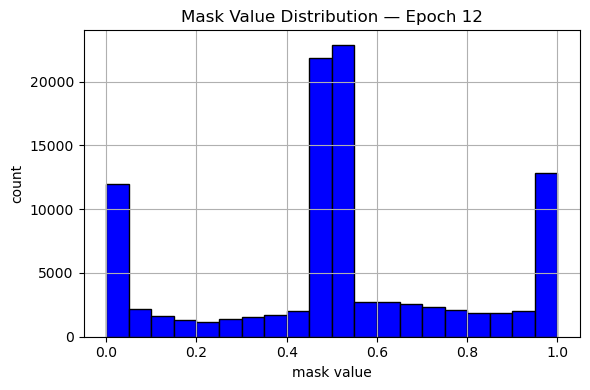

In [ ]:
# ---- PLOT MASK HISTOGRAM ------------------------------------------
plt.figure(figsize=(6, 4))
plt.hist(flat_mask, bins=20, range=(0, 1), color='blue', edgecolor='black')
plt.title(f"Mask Value Distribution — Epoch {epoch}")
plt.xlabel("mask value")
plt.ylabel("count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [151]:
C_svm = torch.exp(model.log_C).detach()
print("C_svm =", C_svm.item())

tau = model.tau
print("tau =", tau)

lambda_hinge = model.lambda_hinge
print("λ_hinge =", lambda_hinge)

C_svm = 0.8468935700907977
tau = 0.1
λ_hinge = 1.0


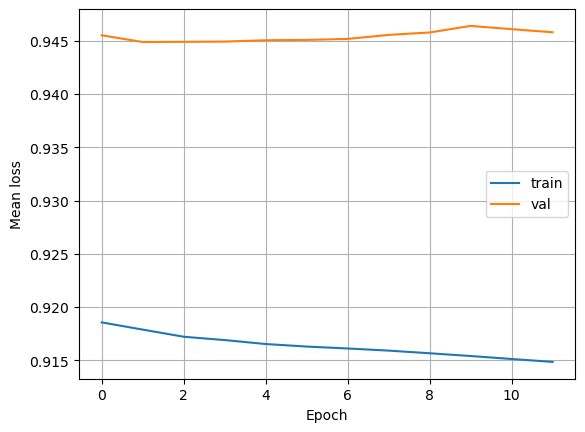

In [152]:
import matplotlib.pyplot as plt 

# --------------------------------------------------------------------
# 2.  load later (anywhere in your code)
# --------------------------------------------------------------------
def load_goal_model(goal, in_features, C, eps, tau, device="cpu"):
    tag   = f"{goal:.3f}".replace(".", "_")
    path  = pathlib.Path("checkpoints") / f"goal_{tag}" / "best_model.pt"
    mdl   = EndToEndSVM_MVO_Sigmoid(in_features, C, eps, tau).to(device)
    mdl.load_state_dict(torch.load(path, map_location=device))
    mdl.eval()
    return mdl

# example usage  
#model = load_goal_model(return_goals[0], in_features=10, C=C_svm, eps=1e-6, tau=tau)

plt.plot(loss_hist, label="train")
plt.plot(val_hist,  label="val")
plt.xlabel("Epoch"); plt.ylabel("Mean loss")
plt.legend(); plt.grid(True); plt.show()

# In-sample

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import cvxpy as cp

def solve_mvo(mask, mu, Sigma, return_goal):
    # mask: length-n (upper bounds, or 1 for selected assets)
    import cvxpy as cp
    n = len(mu)
    w = cp.Variable(n)
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= return_goal,
        w >= 0,
        w <= mask
    ]
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), constraints)
    try:
        prob.solve(solver=cp.OSQP)
        if w.value is not None:
            return np.array(w.value).flatten()
    except Exception as e:
        pass
    return None

# 1. Pre-train SVM classifier once, on all historical training data


X_train = np.vstack([s["X_feat"] for s in train_snaps])
print("X_train shape:", X_train.shape)
y_train = np.hstack([s["y"] for s in train_snaps])
print("y_train shape:", y_train.shape)
svm_clf = SVC(kernel='linear', C=C_svm.item())
svm_clf.fit(X_train, y_train)

X_train shape: (10234, 10)
y_train shape: (10234,)


SVC(C=0.8468935700907977, kernel='linear')

In [154]:
rets_nn, vars_nn = [], []
rets_svm, vars_svm = [], []


for snap in train_snaps:
    X, y, mu, Sigma, real_ret, real_sigma = snap["X_feat"], snap["y"], snap["mu_fore"], snap["Sigma_fore"], snap["real_returns"], snap["real_sigma"]
    
    # Check if SVM has more than one class
    if len(np.unique(y)) < 2:
        continue

    # check if mu_fore is feasible
    if mu.max() < return_goals[0]:
        print(f"Skipping snapshot: return_goal={return_goals[0]} not feasible (max mu = {mu.max():.4f})")
        continue
    # ---- NN Efficient Frontier ----
    X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))

    mu_np = np.asarray(mu)
    Sigma_np = np.asarray(Sigma)

    real_mu_np = np.asarray(real_ret)
    real_sigma_np = np.asarray(real_sigma)

    with torch.no_grad():
        w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
    w_nn = w_nn.cpu().numpy()
    ret_nn = real_mu_np @ w_nn
    var_nn = w_nn @ real_sigma_np @ w_nn

    # ---- SVM then MVO ----
    scores = svm_clf.decision_function(X)
    selected = scores > 0
    if selected.sum() < 2:
        continue  # skip this snapshot

    mu_sel = mu_np[selected]
    Sigma_sel = Sigma_np[np.ix_(selected, selected)]
    real_mu_sel = real_mu_np[selected]
    real_sigma_sel = real_sigma_np[np.ix_(selected, selected)]

    w_svm = solve_mvo(np.ones(len(mu_sel)), mu_sel, Sigma_sel, return_goals[0])
    if w_svm is None:
        continue

    ret_svm = real_mu_sel @ w_svm
    var_svm = w_svm @ real_sigma_sel @ w_svm

    rets_nn.append(ret_nn)
    vars_nn.append(var_nn)
    rets_svm.append(ret_svm)
    vars_svm.append(var_svm)

mean_ret_nn = np.mean(rets_nn)
mean_var_nn = np.mean(vars_nn)
sharpe_nn = mean_ret_nn / (np.std(rets_nn))

mean_ret_svm = np.mean(rets_svm)
mean_var_svm = np.mean(vars_svm)
sharpe_svm = mean_ret_svm / (np.std(rets_svm))
    

Skipping snapshot: return_goal=0.05 not feasible (max mu = 0.0404)
Skipping snapshot: return_goal=0.05 not feasible (max mu = 0.0319)


In [155]:
print(f"NN: Mean Return = {mean_ret_nn:.4f}, Variance = {mean_var_nn:.4f}, Sharpe = {sharpe_nn:.4f}")
print(f"SVM: Mean Return = {mean_ret_svm:.4f}, Variance = {mean_var_svm:.4f}, Sharpe = {sharpe_svm:.4f}")

NN: Mean Return = 0.0567, Variance = 0.0014, Sharpe = 1.6070
SVM: Mean Return = 0.0554, Variance = 0.0013, Sharpe = 1.6328


## not using

In [156]:
# import numpy as np
# import matplotlib.pyplot as plt

# n_pts = 30
# sigmas_nn, mus_nn = [], []
# sigmas_svm, mus_svm = [], []

# for snap in train_snaps:
#     X, y, mu, Sigma, real_ret, real_sigma = snap["X_feat"], snap["y"], snap["mu_fore"], snap["Sigma_fore"], snap["real_returns"], snap["real_sigma"]
    
#     # Check if SVM has more than one class
#     if len(np.unique(y)) < 2:
#         continue

#     # ---- NN Efficient Frontier ----
#     X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
    
#     mu_np = np.asarray(mu)
#     Sigma_np = np.asarray(Sigma)

#     real_mu_np = np.asarray(real_ret)
#     real_sigma_np = np.asarray(real_sigma)

#     sigma_nn, mu_nn = [], []
#     for goal in np.linspace(mu_np.min(), mu_np.max(), n_pts):
#         with torch.no_grad():
#             w, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=goal)
#         w = w.cpu().numpy()  # convert to numpy array
#         if w is not None:
#             sigma_nn.append(np.sqrt(w @ real_sigma_np @ w))
#             mu_nn.append(real_mu_np @ w)
#     if len(sigma_nn) == n_pts:
#         sigmas_nn.append(sigma_nn)
#         mus_nn.append(mu_nn)

#     # ---- SVM+MVO Efficient Frontier ----

#     scores = svm_clf.decision_function(X)
#     selected = scores > 0
#     if selected.sum() < 2:
#         continue
#     mu_sel = mu_np[selected]
#     real_mu_sel = real_mu_np[selected]

#     Sigma_sel = Sigma_np[np.ix_(selected, selected)]
#     real_sigma_np = real_sigma_np[np.ix_(selected, selected)]

#     sigma_svm, mu_svm = [], []
#     for goal in np.linspace(mu_sel.min(), mu_sel.max(), n_pts):
#         w = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, goal)
#         if w is not None:
#             sigma_svm.append(np.sqrt(w @ real_sigma_np @ w))
#             mu_svm.append(real_mu_sel @ w)
#     if len(sigma_svm) == n_pts:
#         sigmas_svm.append(sigma_svm)
#         mus_svm.append(mu_svm)

# # Convert to arrays for easier averaging
# sigmas_nn = np.array(sigmas_nn)
# mus_nn = np.array(mus_nn)
# sigmas_svm = np.array(sigmas_svm)
# mus_svm = np.array(mus_svm)

# # Compute averages
# mean_sig_nn, mean_mu_nn = sigmas_nn.mean(axis=0), mus_nn.mean(axis=0)
# mean_sig_svm, mean_mu_svm = sigmas_svm.mean(axis=0), mus_svm.mean(axis=0)

# # Plot
# plt.figure(figsize=(8,5))
# plt.plot(mean_sig_nn, mean_mu_nn, label="End-to-End NN", marker='o')
# plt.plot(mean_sig_svm, mean_mu_svm, label="SVM+MVO", marker='x')
# plt.xlabel("Portfolio Risk (Std Dev)")
# plt.ylabel("Portfolio Expected Return")
# plt.title("Average Efficient Frontiers Across All Valid Snapshots")
# plt.legend()
# plt.grid(True)
# plt.show()

# Out-of-sample

In [157]:
def make_spd_np(M, eps=1e-6):
    M = (M + M.T) * 0.5
    I = np.eye(M.shape[0], dtype=M.dtype)
    jitter = eps
    for _ in range(10):
        try:
            np.linalg.cholesky(M)
            return M
        except np.linalg.LinAlgError:
            M = M + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

In [158]:
for i in range(len(test_snaps)):
    print((test_snaps[i]['y'] == -1).sum(), (test_snaps[i]['y'] == 1).sum())

28 58
21 65
63 23
24 62
56 30
20 66
37 49
36 50
63 23
18 68
75 11


In [159]:
results_aligned = []

for snap in val_snaps:
    X = snap["X_feat"]
    y = snap["y"]
    mu = snap["mu_fore"]
    Sigma = snap["Sigma_fore"]
    real_returns = snap["real_returns"]
    real_sigma = snap["real_sigma"]

    # If your snapshots include tickers:
    asset_names = np.asarray(snap.get("tickers", np.arange(len(X))))

    try:
        # ================== NN Portfolio ====================
        X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
        with torch.no_grad():
            w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
        w_nn = w_nn.cpu().numpy()
        mask_np = mask.cpu().numpy()

        realized_nn = real_returns
        port_ret_nn = (w_nn * realized_nn).sum()
        port_var_nn = w_nn @ real_sigma @ w_nn
        port_sharpe_nn = port_ret_nn / (np.sqrt(port_var_nn) + 1e-8)

        nn_selected_idx = np.where(w_nn > 1e-6)[0]
        nn_selected_names = asset_names[nn_selected_idx]

        # ================== SVM+MVO Portfolio ====================        
        scores = svm_clf.decision_function(X)
        selected = scores > 0

        if selected.sum() < 2:
            print(f"Skipping {snap['date']} (SVM selected too few assets)")
            continue

        mu_sel = mu[selected]
        Sigma_sel = Sigma[np.ix_(selected, selected)]
        Sigma_sel = make_spd_np(Sigma_sel)  # Ensure SPD

        w_svm = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, return_goal=return_goals[0])
        if w_svm is None:
            print(f"Skipping {snap['date']} (SVM+MVO infeasible)")
            continue

        realized_svm = real_returns[selected]
        real_sigma_svm = real_sigma[np.ix_(selected, selected)]
        port_ret_svm = (w_svm * realized_svm).sum()
        port_var_svm = w_svm @ real_sigma_svm @ w_svm
        port_sharpe_svm = port_ret_svm / (np.sqrt(port_var_svm) + 1e-8)

        svm_selected_idx = np.where(w_svm > 1e-6)[0]
        svm_selected_names = asset_names[svm_selected_idx]

        # ================== Append aligned results ====================
        results_aligned.append({
            "date": snap["date"],
            "nn_return": port_ret_nn,
            "nn_variance": port_var_nn,
            "nn_sharpe": port_sharpe_nn,
            "nn_selected_idx": nn_selected_idx.tolist(),
            "nn_selected_names": nn_selected_names.tolist(),
            "svm_return": port_ret_svm,
            "svm_variance": port_var_svm,
            "svm_sharpe": port_sharpe_svm,
            "svm_selected_idx": svm_selected_idx.tolist(),
            "svm_selected_names": svm_selected_names.tolist(),
        })

    except Exception as e:
        print(f"Skipping {snap['date']} due to error: {e}")
        continue

# ================== Compute aligned comparisons ====================

rets_nn = [r["nn_return"] for r in results_aligned]
rets_svm = [r["svm_return"] for r in results_aligned]
vars_nn = [r["nn_variance"] for r in results_aligned]
vars_svm = [r["svm_variance"] for r in results_aligned]
sharpe_nn = [r["nn_sharpe"] for r in results_aligned]
sharpe_svm = [r["svm_sharpe"] for r in results_aligned]

print(f"\nAligned on {len(results_aligned)} snapshots.")
print(f"NN Mean Return: {np.mean(rets_nn):.6f}, Mean Variance: {np.mean(vars_nn):.6f}")
print(f"SVM+MVO Mean Return: {np.mean(rets_svm):.6f}, Mean Variance: {np.mean(vars_svm):.6f}")
print(f"NN Sharpe: {np.mean(sharpe_nn):.6f}")
print(f"SVM+MVO Sharpe: {np.mean(sharpe_svm):.6f}")


Aligned on 12 snapshots.
NN Mean Return: 0.051060, Mean Variance: 0.003056
SVM+MVO Mean Return: 0.050972, Mean Variance: 0.003050
NN Sharpe: 1.094111
SVM+MVO Sharpe: 1.084861


In [160]:
print("NN Out-of-Sample: Mean Return:", np.mean(rets_nn), "Mean Variance:", np.mean(vars_nn))
print("SVM+MVO Out-of-Sample: Mean Return:", np.mean(rets_svm), "Mean Variance:", np.mean(vars_svm))
print("NN Sharpe:", np.mean(sharpe_nn))
print("SVM+MVO Sharpe:", np.mean(sharpe_svm))

if np.mean(rets_nn) > np.mean(rets_svm):
    print("NN outperforms SVM+MVO in terms of mean return.")
else:
    print("SVM+MVO outperforms NN in terms of mean return.")
if np.mean(vars_nn) < np.mean(vars_svm):
    print("NN outperforms SVM+MVO in terms of variance.")
else:
    print("SVM+MVO outperforms NN in terms of variance.")
if np.mean(sharpe_nn)  > np.mean(sharpe_svm):
    print("NN outperforms SVM+MVO in terms of Sharpe ratio.")
else:
    print("SVM+MVO outperforms NN in terms of Sharpe ratio.")

NN Out-of-Sample: Mean Return: 0.051060116767464525 Mean Variance: 0.0030558455996507056
SVM+MVO Out-of-Sample: Mean Return: 0.05097160822378177 Mean Variance: 0.0030502105858067987
NN Sharpe: 1.0941108012711978
SVM+MVO Sharpe: 1.0848607594033801
NN outperforms SVM+MVO in terms of mean return.
SVM+MVO outperforms NN in terms of variance.
NN outperforms SVM+MVO in terms of Sharpe ratio.


In [161]:
# use results_aligned

for r in results_aligned:
    print(f"Date: {r['date']}")
    print(f"  NN Return: {r['nn_return']:.6f}, Variance: {r['nn_variance']:.6f}, Selected Assets: {len(r['nn_selected_names'])}")
    print(f"  SVM+MVO Return: {r['svm_return']:.6f}, Variance: {r['svm_variance']:.6f}, Selected Assets: {len(r['svm_selected_names'])}")

Date: 2023-01-31 00:00:00
  NN Return: 0.018253, Variance: 0.003448, Selected Assets: 84
  SVM+MVO Return: 0.027837, Variance: 0.003071, Selected Assets: 27
Date: 2023-02-28 00:00:00
  NN Return: 0.039045, Variance: 0.005724, Selected Assets: 63
  SVM+MVO Return: 0.039045, Variance: 0.005724, Selected Assets: 63
Date: 2023-03-31 00:00:00
  NN Return: 0.062792, Variance: 0.001681, Selected Assets: 34
  SVM+MVO Return: 0.063646, Variance: 0.001778, Selected Assets: 35
Date: 2023-04-30 00:00:00
  NN Return: 0.026228, Variance: 0.002998, Selected Assets: 84
  SVM+MVO Return: 0.025155, Variance: 0.003011, Selected Assets: 20
Date: 2023-05-31 00:00:00
  NN Return: 0.102031, Variance: 0.003550, Selected Assets: 21
  SVM+MVO Return: 0.102031, Variance: 0.003550, Selected Assets: 21
Date: 2023-06-30 00:00:00
  NN Return: 0.082103, Variance: 0.002824, Selected Assets: 14
  SVM+MVO Return: 0.082103, Variance: 0.002824, Selected Assets: 14
Date: 2023-07-31 00:00:00
  NN Return: 0.012610, Variance:

# Test

In [123]:
results_aligned = []

for snap in test_snaps:
    X = snap["X_feat"]
    y = snap["y"]
    mu = snap["mu_fore"]
    Sigma = snap["Sigma_fore"]
    real_returns = snap["real_returns"]
    real_sigma = snap["real_sigma"]

    # If your snapshots include tickers:
    asset_names = np.asarray(snap.get("tickers", np.arange(len(X))))

    try:
        # ================== NN Portfolio ====================
        X_t, y_t, mu_t, Sigma_t = map(lambda x: torch.tensor(x).double(), (X, y, mu, Sigma))
        with torch.no_grad():
            w_nn, mask, _, _ = model(X_t, y_t, mu_t, Sigma_t, return_goal=return_goals[0])
        w_nn = w_nn.cpu().numpy()
        mask_np = mask.cpu().numpy()

        realized_nn = real_returns[:len(w_nn)]
        port_ret_nn = (w_nn * realized_nn).sum()
        port_var_nn = w_nn @ real_sigma[:len(w_nn), :len(w_nn)] @ w_nn

        nn_selected_idx = np.where(w_nn > 1e-5)[0]
        nn_selected_names = asset_names[nn_selected_idx]

        # ================== SVM+MVO Portfolio ====================
        scores = svm_clf.decision_function(X)
        selected = scores > 0

        if selected.sum() < 2:
            print(f"Skipping {snap['date']} (SVM selected too few assets)")
            continue

        mu_sel = mu[selected]
        Sigma_sel = Sigma[np.ix_(selected, selected)]
        Sigma_sel = make_spd_np(Sigma_sel)  # Ensure SPD

        w_svm = solve_mvo(np.ones(mu_sel.shape), mu_sel, Sigma_sel, return_goal=return_goals[0])
        if w_svm is None:
            print(f"Skipping {snap['date']} (SVM+MVO infeasible)")
            continue

        realized_svm = real_returns[selected]
        real_sigma_svm = real_sigma[np.ix_(selected, selected)]
        port_ret_svm = (w_svm * realized_svm).sum()
        port_var_svm = w_svm @ real_sigma_svm @ w_svm

        svm_selected_idx = np.where(w_svm > 1e-5)[0]
        svm_selected_names = asset_names[svm_selected_idx]

        # ================== Append aligned results ====================
        results_aligned.append({
            "date": snap["date"],
            "nn_return": port_ret_nn,
            "nn_variance": port_var_nn,
            "nn_selected_idx": nn_selected_idx.tolist(),
            "nn_selected_names": nn_selected_names.tolist(),
            "svm_return": port_ret_svm,
            "svm_variance": port_var_svm,
            "svm_selected_idx": svm_selected_idx.tolist(),
            "svm_selected_names": svm_selected_names.tolist(),
        })

    except Exception as e:
        print(f"Skipping {snap['date']} due to error: {e}")
        continue

# ================== Compute aligned comparisons ====================

rets_nn = [r["nn_return"] for r in results_aligned]
rets_svm = [r["svm_return"] for r in results_aligned]
vars_nn = [r["nn_variance"] for r in results_aligned]
vars_svm = [r["svm_variance"] for r in results_aligned]

print(f"\nAligned on {len(results_aligned)} snapshots.")
print(f"NN Mean Return: {np.mean(rets_nn):.6f}, Mean Variance: {np.mean(vars_nn):.6f}")
print(f"SVM+MVO Mean Return: {np.mean(rets_svm):.6f}, Mean Variance: {np.mean(vars_svm):.6f}")
print(f"NN Sharpe: {np.mean(rets_nn)/np.std(rets_nn):.6f}")
print(f"SVM+MVO Sharpe: {np.mean(rets_svm)/np.std(rets_svm):.6f}")


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

Skipping 2024-04-30 00:00:00 (SVM+MVO infeasible)

Aligned on 10 snapshots.
NN Mean Return: 0.064086, Mean Variance: 0.001707
SVM+MVO Mean Return: 0.058675, Mean Variance: 0.001613
NN Sharpe: 1.865631
SVM+MVO Sharpe: 1.610391


In [124]:
print("NN Out-of-Sample: Mean Return:", np.mean(rets_nn), "Mean Variance:", np.mean(vars_nn))
print("SVM+MVO Out-of-Sample: Mean Return:", np.mean(rets_svm), "Mean Variance:", np.mean(vars_svm))
print("NN Sharpe:", np.mean(rets_nn) / np.std(rets_nn))
print("SVM+MVO Sharpe:", np.mean(rets_svm) / np.std(rets_svm))

if np.mean(rets_nn) > np.mean(rets_svm):
    print("NN outperforms SVM+MVO in terms of mean return.")
else:
    print("SVM+MVO outperforms NN in terms of mean return.")
if np.mean(vars_nn) < np.mean(vars_svm):
    print("NN outperforms SVM+MVO in terms of variance.")
else:
    print("SVM+MVO outperforms NN in terms of variance.")
if np.mean(rets_nn) / np.std(rets_nn) > np.mean(rets_svm) / np.std(rets_svm):
    print("NN outperforms SVM+MVO in terms of Sharpe ratio.")
else:
    print("SVM+MVO outperforms NN in terms of Sharpe ratio.")

NN Out-of-Sample: Mean Return: 0.06408602500444702 Mean Variance: 0.0017066805664551292
SVM+MVO Out-of-Sample: Mean Return: 0.05867508531493715 Mean Variance: 0.0016125466222726714
NN Sharpe: 1.8656312618259718
SVM+MVO Sharpe: 1.610391182358715
NN outperforms SVM+MVO in terms of mean return.
SVM+MVO outperforms NN in terms of variance.
NN outperforms SVM+MVO in terms of Sharpe ratio.


In [125]:
# use results_aligned

for r in results_aligned:
    print(f"Date: {r['date']}")
    print(f"  NN Return: {r['nn_return']:.6f}, Variance: {r['nn_variance']:.6f}, Selected Assets: {len(r['nn_selected_names'])}")
    print(f"  SVM+MVO Return: {r['svm_return']:.6f}, Variance: {r['svm_variance']:.6f}, Selected Assets: {len(r['svm_selected_names'])}")

Date: 2024-01-31 00:00:00
  NN Return: 0.064259, Variance: 0.001499, Selected Assets: 37
  SVM+MVO Return: 0.063888, Variance: 0.001444, Selected Assets: 39
Date: 2024-02-29 00:00:00
  NN Return: 0.047093, Variance: 0.001401, Selected Assets: 63
  SVM+MVO Return: 0.047093, Variance: 0.001401, Selected Assets: 63
Date: 2024-03-31 00:00:00
  NN Return: 0.046532, Variance: 0.001836, Selected Assets: 12
  SVM+MVO Return: 0.046532, Variance: 0.001836, Selected Assets: 12
Date: 2024-05-31 00:00:00
  NN Return: 0.049780, Variance: 0.000689, Selected Assets: 29
  SVM+MVO Return: 0.049780, Variance: 0.000689, Selected Assets: 29
Date: 2024-06-30 00:00:00
  NN Return: 0.072115, Variance: 0.001127, Selected Assets: 63
  SVM+MVO Return: 0.046392, Variance: 0.001103, Selected Assets: 44
Date: 2024-07-31 00:00:00
  NN Return: 0.081135, Variance: 0.001132, Selected Assets: 28
  SVM+MVO Return: 0.081519, Variance: 0.001100, Selected Assets: 24
Date: 2024-08-31 00:00:00
  NN Return: 0.057623, Variance:

FileNotFoundError: [Errno 2] No such file or directory: 'plots/9curve.png'

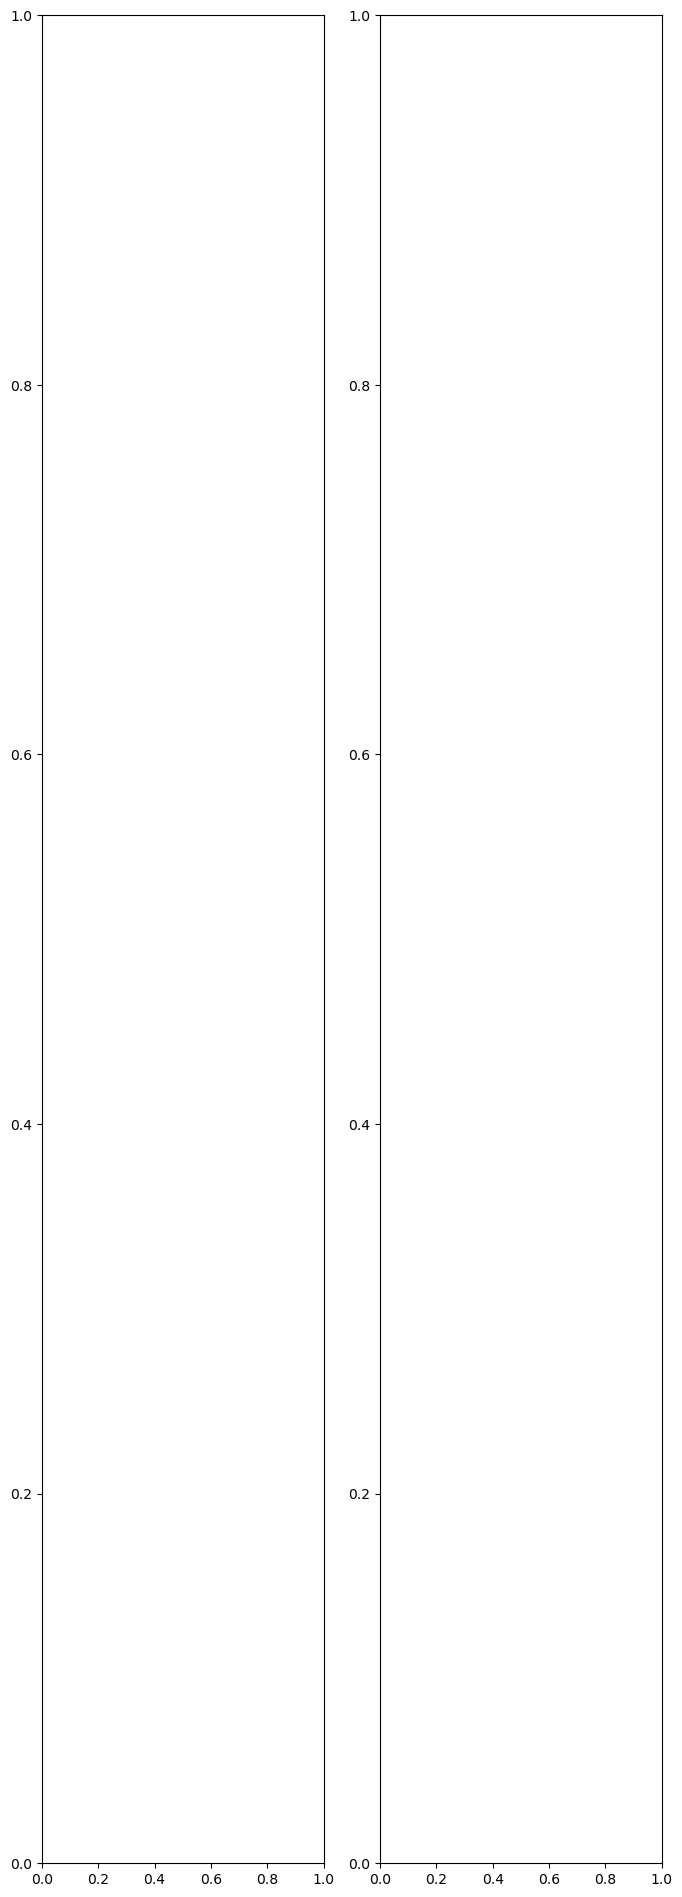

In [126]:
import matplotlib.pyplot as plt

# List of your PNG files
png_files = ['plots/9curve.png', 'plots/9eff.png']  # replace with your file names

n = len(png_files)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 24))

# Flatten axes for easy iteration (handles 1D/2D arrays)
axes = axes.flatten()

for ax, img_file in zip(axes, png_files):
    img = plt.imread(img_file)
    ax.imshow(img)
    ax.axis('off')  # Hide axes ticks

# Hide unused subplots, if any
for ax in axes[len(png_files):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig('plots/9combined.png', bbox_inches='tight', dpi=300)
plt.show()
# save the figure
